In [1]:
import pandas as pd
import shutil
import os

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
import numpy as np

2023-06-10 20:06:14.317737: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-10 20:06:14.944883: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv('/home/ros2/Documents/IA/base.csv')
classes = ['Philodryas olfersii', 'Boa constrictor', 'Oxyrhopus guibei']
df = df[df['binomial_name'].isin(classes)]
df = df[['file_path', 'binomial_name']].copy()

In [3]:
# crie uma pasta para cada classe sabendo que o nome da pasta sera a coluna binomial_name
for classe in classes:
    shutil.rmtree(classe, ignore_errors=True)
    os.mkdir(classe)

# copie as imagens para as pastas
for index, row in df.iterrows():
    shutil.copy("base/" + row['file_path'], row['binomial_name'])


In [4]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='base_tratada/',
    validation_split=0.2,
    subset='training',
    seed=123,
    batch_size=32,
    image_size=(256, 256))

Found 1263 files belonging to 3 classes.
Using 1011 files for training.


2023-06-10 20:06:17.034556: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-10 20:06:17.065817: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-10 20:06:17.066145: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory='base_tratada/',
    validation_split=0.2,
    subset='validation',
    seed=123,
    batch_size=32,
    image_size=(256, 256))

Found 1263 files belonging to 3 classes.
Using 252 files for validation.


In [6]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory='base_tratada/',
    validation_split=0.2,
    subset='validation',
    seed=123,
    batch_size=32,
    image_size=(256, 256))

Found 1263 files belonging to 3 classes.
Using 252 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['Boa constrictor', 'Oxyrhopus guibei', 'Philodryas olfersii']


2023-06-10 20:06:18.095024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1011]
	 [[{{node Placeholder/_0}}]]
2023-06-10 20:06:18.095278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1011]
	 [[{{node Placeholder/_4}}]]


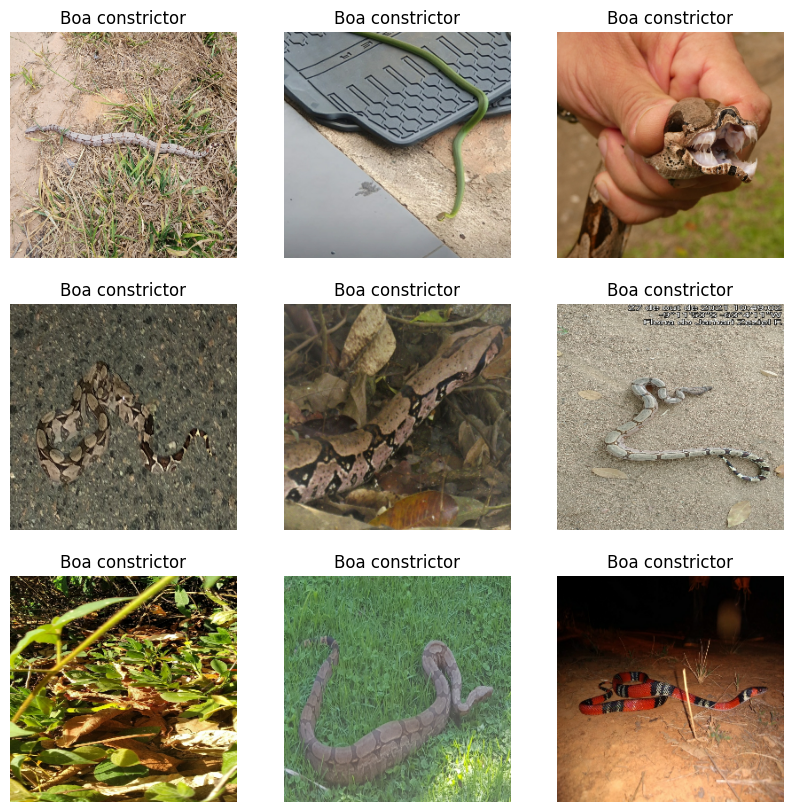

In [8]:
#crie uma função que exiba 9 imagens aleatórias do dataset

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(9):
        ax = plt.subplot(3, 3, n+1)
        plt.imshow(image_batch[n].astype('uint8'))
        plt.title(class_names[np.argmax(label_batch[n])])
        plt.axis('off')

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())


In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

2023-06-10 20:06:19.907189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1011]
	 [[{{node Placeholder/_4}}]]
2023-06-10 20:06:19.907494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1011]
	 [[{{node Placeholder/_4}}]]


0.0 0.8900123


In [13]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

In [16]:
epochs=200
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/200


2023-06-10 20:06:21.884650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1011]
	 [[{{node Placeholder/_4}}]]
2023-06-10 20:06:21.885257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1011]
	 [[{{node Placeholder/_4}}]]
2023-06-10 20:06:23.152811: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-10 20:06:24.075815: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f836b543da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
202

32/32 [==============================] - ETA: 0s - loss: 1.1069 - accuracy: 0.4817

2023-06-10 20:06:27.661040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [252]
	 [[{{node Placeholder/_0}}]]
2023-06-10 20:06:27.661368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [252]
	 [[{{node Placeholder/_4}}]]


32/32 [==============================] - 7s 81ms/step - loss: 1.1069 - accuracy: 0.4817 - val_loss: 0.9470 - val_accuracy: 0.5754
Epoch 2/200
32/32 [==============================] - 1s 33ms/step - loss: 0.9329 - accuracy: 0.5618 - val_loss: 0.9050 - val_accuracy: 0.5833
Epoch 3/200
32/32 [==============================] - 1s 32ms/step - loss: 0.8330 - accuracy: 0.6518 - val_loss: 0.8896 - val_accuracy: 0.6389
Epoch 4/200
32/32 [==============================] - 1s 32ms/step - loss: 0.6777 - accuracy: 0.7132 - val_loss: 0.8499 - val_accuracy: 0.6151
Epoch 5/200
32/32 [==============================] - 1s 33ms/step - loss: 0.5183 - accuracy: 0.7755 - val_loss: 0.8371 - val_accuracy: 0.6667
Epoch 6/200
32/32 [==============================] - 1s 33ms/step - loss: 0.4539 - accuracy: 0.8220 - val_loss: 1.0080 - val_accuracy: 0.6270
Epoch 7/200
32/32 [==============================] - 1s 33ms/step - loss: 0.3147 - accuracy: 0.8902 - val_loss: 1.1191 - val_accuracy: 0.6190
Epoch 8/200
32/32 

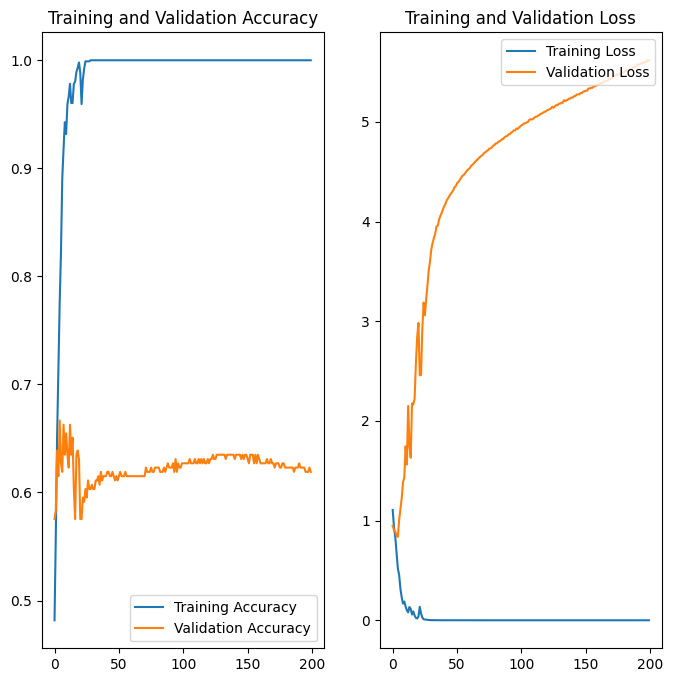

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()